Corporaci√≥n Favorita ‚Äî a major Ecuadorian supermarket and retail chain
Headquartered in Quito, operating stores like Supermaxi and Megamaxi nationwide

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

import osmnx as ox
import geopandas as gpd
from geopy.geocoders import Nominatim
from tqdm import tqdm
from geopy.extra.rate_limiter import RateLimiter
from shapely.geometry import Point

from time import sleep

import psycopg2
import warnings
import sqlite3
import sqlalchemy as sa

from sqlalchemy import text
from sqlalchemy import create_engine

import matplotlib.patches as mpatches

import contextily as ctx

import requests
import json
from pathlib import Path
import os, json, time

# opening the data
import re
from datetime import datetime, time

from itertools import combinations
import gc # gc.collect()

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [3]:
import joblib # Save the DataFrame to a compressed file

In [4]:
# from google.colab import files

In [5]:
# !pip install kagglehub
import kagglehub

---------------------------------------------------
---------------------------------------------------

# Data initial review and download

In [6]:
# Download latest version
path = kagglehub.dataset_download("siliconx/favoritagrocerysalesforecastingextracted")

print("Path to dataset files:", path)

Path to dataset files: /Users/georgeshmelin/.cache/kagglehub/datasets/siliconx/favoritagrocerysalesforecastingextracted/versions/1


In [7]:
files = os.listdir(path)
print("Files in dataset:", files)

Files in dataset: ['test.csv', 'train.csv', 'transactions.csv', 'items.csv', 'oil.csv', 'holidays_events.csv', 'sample_submission.csv', 'stores.csv']


In [8]:
del files
gc.collect()

0

## Data overview

In [9]:
files = os.listdir(path)
print("Files in dataset:", files)

Files in dataset: ['test.csv', 'train.csv', 'transactions.csv', 'items.csv', 'oil.csv', 'holidays_events.csv', 'sample_submission.csv', 'stores.csv']


### oil

In [10]:
# Connect to SQLite
conn = sqlite3.connect("favorita.db")

# Change this line per file
filename = 'oil.csv'
file_path = os.path.join(path, filename)

# Load CSV
df = pd.read_csv(file_path)
table_name = filename.replace('.csv', '')

# Load to SQL
df.to_sql(table_name, conn, if_exists="replace", index=False)
print(f"‚úÖ Loaded '{filename}' into table '{table_name}'")

# Row count
query = f"SELECT COUNT(*) AS row_count FROM {table_name};"
row_count_df = pd.read_sql(query, conn)
row_count = row_count_df.iloc[0, 0]
print(f"üî¢ Table '{table_name}' has {row_count:,} rows.")

# Inspect columns for key info
columns = df.columns.tolist()
primary_like = [col for col in columns if 'id' in col.lower() or 'nbr' in col.lower()]
date_like = [col for col in columns if 'date' in col.lower()]
possible_keys = primary_like + date_like

# Show candidate keys
if possible_keys:
    print(f"üîë Candidate keys or join fields in '{table_name}': {possible_keys}")
else:
    print(f"‚ÑπÔ∏è No obvious join keys found in '{table_name}'")
     

‚úÖ Loaded 'oil.csv' into table 'oil'
üî¢ Table 'oil' has 1,218 rows.
üîë Candidate keys or join fields in 'oil': ['date']


### items

In [11]:
# Change this line per file
filename = 'items.csv'
file_path = os.path.join(path, filename)

# Load CSV
df = pd.read_csv(file_path)
table_name = filename.replace('.csv', '')

# Load to SQL
df.to_sql(table_name, conn, if_exists="replace", index=False)
print(f"‚úÖ Loaded '{filename}' into table '{table_name}'")

# Row count
query = f"SELECT COUNT(*) AS row_count FROM {table_name};"
row_count_df = pd.read_sql(query, conn)
row_count = row_count_df.iloc[0, 0]
print(f"üî¢ Table '{table_name}' has {row_count:,} rows.")

# Inspect columns for key info
columns = df.columns.tolist()
primary_like = [col for col in columns if 'id' in col.lower() or 'nbr' in col.lower()]
date_like = [col for col in columns if 'date' in col.lower()]
possible_keys = primary_like + date_like

# Show candidate keys
if possible_keys:
    print(f"üîë Candidate keys or join fields in '{table_name}': {possible_keys}")
else:
    print(f"‚ÑπÔ∏è No obvious join keys found in '{table_name}'")

‚úÖ Loaded 'items.csv' into table 'items'
üî¢ Table 'items' has 4,100 rows.
üîë Candidate keys or join fields in 'items': ['item_nbr']


### sample_submission

In [12]:
# Change this line per file
filename = 'sample_submission.csv'
file_path = os.path.join(path, filename)

# Load CSV
df = pd.read_csv(file_path)
table_name = filename.replace('.csv', '')

# Load to SQL
df.to_sql(table_name, conn, if_exists="replace", index=False)
print(f"‚úÖ Loaded '{filename}' into table '{table_name}'")

# Row count
query = f"SELECT COUNT(*) AS row_count FROM {table_name};"
row_count_df = pd.read_sql(query, conn)
row_count = row_count_df.iloc[0, 0]
print(f"üî¢ Table '{table_name}' has {row_count:,} rows.")

# Inspect columns for key info
columns = df.columns.tolist()
primary_like = [col for col in columns if 'id' in col.lower() or 'nbr' in col.lower()]
date_like = [col for col in columns if 'date' in col.lower()]
possible_keys = primary_like + date_like

# Show candidate keys
if possible_keys:
    print(f"üîë Candidate keys or join fields in '{table_name}': {possible_keys}")
else:
    print(f"‚ÑπÔ∏è No obvious join keys found in '{table_name}'")

‚úÖ Loaded 'sample_submission.csv' into table 'sample_submission'
üî¢ Table 'sample_submission' has 3,370,464 rows.
üîë Candidate keys or join fields in 'sample_submission': ['id']


### holidays_events

In [13]:
# Change this line per file
filename = 'holidays_events.csv'
file_path = os.path.join(path, filename)

# Load CSV
df = pd.read_csv(file_path)
table_name = filename.replace('.csv', '')

# Load to SQL
df.to_sql(table_name, conn, if_exists="replace", index=False)
print(f"‚úÖ Loaded '{filename}' into table '{table_name}'")

# Row count
query = f"SELECT COUNT(*) AS row_count FROM {table_name};"
row_count_df = pd.read_sql(query, conn)
row_count = row_count_df.iloc[0, 0]
print(f"üî¢ Table '{table_name}' has {row_count:,} rows.")

# Inspect columns for key info
columns = df.columns.tolist()
primary_like = [col for col in columns if 'id' in col.lower() or 'nbr' in col.lower()]
date_like = [col for col in columns if 'date' in col.lower()]
possible_keys = primary_like + date_like

# Show candidate keys
if possible_keys:
    print(f"üîë Candidate keys or join fields in '{table_name}': {possible_keys}")
else:
    print(f"‚ÑπÔ∏è No obvious join keys found in '{table_name}'")

‚úÖ Loaded 'holidays_events.csv' into table 'holidays_events'
üî¢ Table 'holidays_events' has 350 rows.
üîë Candidate keys or join fields in 'holidays_events': ['date']


### stores

In [14]:
# Set up file
filename = 'stores.csv'
file_path = os.path.join(path, filename)

# Load and filter for Guayas
df = pd.read_csv(file_path)

table_name = filename.replace('.csv', '')

# Save to SQL
df.to_sql(table_name, conn, if_exists="replace", index=False)

# Row count
query = f"SELECT COUNT(*) AS row_count FROM {table_name};"
row_count_df = pd.read_sql(query, conn)
row_count = row_count_df.iloc[0, 0]
print(f"üî¢ Table '{table_name}' has {row_count:,} rows.")

# Inspect columns for join keys
columns = df.columns.tolist()
primary_like = [col for col in columns if 'id' in col.lower() or 'nbr' in col.lower()]
date_like = [col for col in columns if 'date' in col.lower()]
possible_keys = primary_like + date_like

# Show candidate keys
if possible_keys:
    print(f"üîë Candidate keys or join fields in '{table_name}': {possible_keys}")
else:
    print(f"‚ÑπÔ∏è No obvious join keys found in '{table_name}'")

üî¢ Table 'stores' has 54 rows.
üîë Candidate keys or join fields in 'stores': ['store_nbr']


### transactions

In [15]:
# Change this line per file
filename = 'transactions.csv'
file_path = os.path.join(path, filename)

# Load CSV
df = pd.read_csv(file_path)
table_name = filename.replace('.csv', '')

# Load to SQL
df.to_sql(table_name, conn, if_exists="replace", index=False)
print(f"‚úÖ Loaded '{filename}' into table '{table_name}'")

# Row count
query = f"SELECT COUNT(*) AS row_count FROM {table_name};"
row_count_df = pd.read_sql(query, conn)
row_count = row_count_df.iloc[0, 0]
print(f"üî¢ Table '{table_name}' has {row_count:,} rows.")

# Inspect columns for key info
columns = df.columns.tolist()
primary_like = [col for col in columns if 'id' in col.lower() or 'nbr' in col.lower()]
date_like = [col for col in columns if 'date' in col.lower()]
possible_keys = primary_like + date_like

# Show candidate keys
if possible_keys:
    print(f"üîë Candidate keys or join fields in '{table_name}': {possible_keys}")
else:
    print(f"‚ÑπÔ∏è No obvious join keys found in '{table_name}'")

‚úÖ Loaded 'transactions.csv' into table 'transactions'
üî¢ Table 'transactions' has 83,488 rows.
üîë Candidate keys or join fields in 'transactions': ['store_nbr', 'date']


### test

In [16]:
# Change this line per file
filename = 'test.csv'
file_path = os.path.join(path, filename)
table_name = filename.replace('.csv', '')

# Load CSV
df = pd.read_csv(file_path, parse_dates=['date'])

# ‚è±Ô∏è Round date to nearest hour
df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.floor('H')

# Save to SQL
df.to_sql(table_name, conn, if_exists="replace", index=False)
print(f"‚úÖ Loaded '{filename}' into table '{table_name}'")

# Row count
query = f"SELECT COUNT(*) AS row_count FROM {table_name};"
row_count = pd.read_sql(query, conn).iloc[0, 0]
print(f"üî¢ Table '{table_name}' has {row_count:,} rows.")

# Inspect for join keys
columns = df.columns.tolist()
primary_like = [col for col in columns if 'id' in col.lower() or 'nbr' in col.lower()]
date_like = [col for col in columns if 'date' in col.lower()]
possible_keys = primary_like + date_like

if possible_keys:
    print(f"üîë Candidate keys or join fields in '{table_name}': {possible_keys}")
else:
    print(f"‚ÑπÔ∏è No obvious join keys found in '{table_name}'")

/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/3503095255.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.floor('H')


‚úÖ Loaded 'test.csv' into table 'test'
üî¢ Table 'test' has 3,370,464 rows.
üîë Candidate keys or join fields in 'test': ['id', 'store_nbr', 'item_nbr', 'date']


### train

In [17]:
# Change this line per file
filename = 'test.csv'
file_path = os.path.join(path, filename)
table_name = filename.replace('.csv', '')

# Load CSV
df = pd.read_csv(file_path, parse_dates=['date'])

# ‚è±Ô∏è Round date to nearest hour
df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.floor('H')

# Save to SQL
df.to_sql(table_name, conn, if_exists="replace", index=False)
print(f"‚úÖ Loaded '{filename}' into table '{table_name}'")

# Row count
query = f"SELECT COUNT(*) AS row_count FROM {table_name};"
row_count = pd.read_sql(query, conn).iloc[0, 0]
print(f"üî¢ Table '{table_name}' has {row_count:,} rows.")

# Inspect for join keys
columns = df.columns.tolist()
primary_like = [col for col in columns if 'id' in col.lower() or 'nbr' in col.lower()]
date_like = [col for col in columns if 'date' in col.lower()]
possible_keys = primary_like + date_like

if possible_keys:
    print(f"üîë Candidate keys or join fields in '{table_name}': {possible_keys}")
else:
    print(f"‚ÑπÔ∏è No obvious join keys found in '{table_name}'")

/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/3503095255.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.floor('H')


‚úÖ Loaded 'test.csv' into table 'test'
üî¢ Table 'test' has 3,370,464 rows.
üîë Candidate keys or join fields in 'test': ['id', 'store_nbr', 'item_nbr', 'date']


In [18]:
del possible_keys
del columns
del date_like
del primary_like
del df
del row_count_df
del query

gc.collect()

0

### Data samples

### df_train - train.csv is a big in this dataset - like 125 million rows, so I need to download only a small sample

In [19]:
# Paths and file setup
filename = 'train.csv'
file_path = os.path.join(path, filename)
table_name = filename.replace('.csv', '')

# Date filter range
DATE_START = '2010-00-00'
DATE_END = '2025-12-31'

# Sampling + row cap
SAMPLE_RATIO = 0.005
MAX_ROWS = 50_000
total_saved_rows = 0

# Columns to keep from CSV
columns_to_keep = ['date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion']

In [20]:
# Connect to SQLite
conn = sqlite3.connect("favorita.db")
cursor = conn.cursor()

# Check if the table exists
cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}'")
table_exists = cursor.fetchone()

# If not exists, create it with correct schema
if not table_exists:
    create_sql = f"""
        CREATE TABLE {table_name} (
            date DATETIME,
            store_nbr INTEGER,
            item_nbr INTEGER,
            unit_sales REAL,
            onpromotion INTEGER
        )
    """
    conn.execute(create_sql)
    print(f"‚úÖ Created table '{table_name}' with all expected columns")
else:
    # Validate column schema
    cursor.execute(f"PRAGMA table_info({table_name})")
    existing_columns = [col[1] for col in cursor.fetchall()]
    if 'onpromotion' not in existing_columns:
        try:
            conn.execute(f"ALTER TABLE {table_name} ADD COLUMN onpromotion INTEGER")
            print(f"‚ûï Added missing column 'onpromotion' to '{table_name}'")
        except sqlite3.OperationalError as e:
            print(f"‚ö†Ô∏è Could not alter table to add 'onpromotion': {e}")
    else:
        print(f"‚ÑπÔ∏è Table '{table_name}' exists and includes 'onpromotion'")

‚ÑπÔ∏è Table 'train' exists and includes 'onpromotion'


In [21]:
# Read CSV in chunks
chunks = pd.read_csv(file_path, chunksize=1_00_000, parse_dates=['date'])

for chunk in chunks:
    # Filter date
    #chunk = chunk[(chunk['date'] >= DATE_START) & (chunk['date'] < DATE_END)]
    if chunk.empty:
        continue

    # Round to hour
    chunk['date'] = pd.to_datetime(chunk['date'], errors='coerce').dt.floor('H')

    # Ensure onpromotion column
    if 'onpromotion' not in chunk.columns:
        chunk['onpromotion'] = 0
    chunk['onpromotion'] = chunk['onpromotion'].fillna(False).astype('int8')  # Make it small

    # Downcast numerics
    chunk['store_nbr'] = pd.to_numeric(chunk['store_nbr'], downcast='integer')
    chunk['item_nbr'] = pd.to_numeric(chunk['item_nbr'], downcast='integer')
    chunk['unit_sales'] = pd.to_numeric(chunk['unit_sales'], downcast='float')

    # Try float16 if it fits (warning: less precise)
    if chunk['unit_sales'].max() < 65504:  # float16 upper limit
        chunk['unit_sales'] = chunk['unit_sales'].astype('float16')

    # Sample
    chunk = chunk.sample(frac=SAMPLE_RATIO, random_state=42)

    # Cap rows
    if total_saved_rows + len(chunk) > MAX_ROWS:
        chunk = chunk.iloc[:MAX_ROWS - total_saved_rows]

    # Keep only expected columns
    chunk = chunk[columns_to_keep]

    # Save
    chunk.to_sql(table_name, conn, if_exists='append', index=False)
    total_saved_rows += len(chunk)

    if total_saved_rows >= MAX_ROWS:
        break

print(f"‚úÖ Loaded {total_saved_rows} rows into '{table_name}'")

/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/2140791596.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  chunk['date'] = pd.to_datetime(chunk['date'], errors='coerce').dt.floor('H')
/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/2140791596.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  chunk['onpromotion'] = chunk['onpromotion'].fillna(False).astype('int8')  # Make it small
/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/2140791596.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  chunk['date'] = pd.to_datetime(chunk['date'], errors='coerce').dt.floor('H')
/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000

‚úÖ Loaded 50000 rows into 'train'


/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/2140791596.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  chunk['date'] = pd.to_datetime(chunk['date'], errors='coerce').dt.floor('H')
/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/2140791596.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  chunk['onpromotion'] = chunk['onpromotion'].fillna(False).astype('int8')  # Make it small
/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/2140791596.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  chunk['date'] = pd.to_datetime(chunk['date'], errors='coerce').dt.floor('H')
/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000

In [22]:
chunk['onpromotion'] = chunk['onpromotion'].fillna(False).astype('int8')
chunk['unit_sales'] = pd.to_numeric(chunk['unit_sales'], downcast='float')
if chunk['unit_sales'].max() < 65504:
    chunk['unit_sales'] = chunk['unit_sales'].astype('float16')

In [23]:
# Row count
row_count = pd.read_sql(f"SELECT COUNT(*) AS row_count FROM {table_name}", conn).iloc[0, 0]
print(f"üî¢ Table '{table_name}' has {row_count:,} rows.")

# Keys for join
sample = pd.read_sql(f"SELECT * FROM {table_name} LIMIT 5", conn)
columns = sample.columns.tolist()
keys = [col for col in columns if 'id' in col.lower() or 'nbr' in col.lower() or 'date' in col.lower()]
print(f"üîë Candidate keys or join fields in '{table_name}': {keys}")

üî¢ Table 'train' has 1,400,000 rows.
üîë Candidate keys or join fields in 'train': ['date', 'store_nbr', 'item_nbr']


In [24]:
del cursor
del row_count
del sample
del keys
del columns

From SQL to DataFrame

In [25]:
database_connection_string = "sqlite:///favorita.db"  # Assuming the database file is named 'favorita.db'

# Create the engine
engine = sa.create_engine(database_connection_string)

In [26]:
query_train = """
WITH top_families AS (
    SELECT items.family
    FROM train
    JOIN items ON train.item_nbr = items.item_nbr
    WHERE train.unit_sales >= 0
    GROUP BY items.family
    ORDER BY SUM(train.unit_sales) DESC
    LIMIT 10
)

SELECT
    train.unit_sales,
    train.date AS train_date,
    train.store_nbr,
    train.item_nbr,
    train.onpromotion,

    oil.dcoilwtico,

    holidays_events.type AS holiday_type,
    holidays_events.locale,
    holidays_events.transferred,

    stores.city,
    stores.type AS store_type,
    stores.cluster AS store_cluster,

    items.family AS items_family,
    items.class AS item_class,
    items.perishable AS perishable_items,

    transactions.transactions

FROM train
LEFT JOIN oil
  ON DATE(train.date) = DATE(oil.date)
LEFT JOIN holidays_events
  ON DATE(train.date) = DATE(holidays_events.date)
LEFT JOIN stores
  ON train.store_nbr = stores.store_nbr
INNER JOIN items
  ON train.item_nbr = items.item_nbr
INNER JOIN transactions
  ON DATE(train.date) = DATE(transactions.date)
     AND train.store_nbr = transactions.store_nbr

WHERE train.unit_sales >= 0
  AND items.family IN (SELECT family FROM top_families)
  AND train.date > '2010-04-01'

LIMIT 100000;
"""

In [27]:
df_train_download = pd.read_sql_query(query_train, engine)

In [28]:
df_train_download.sample(5)

unit_sales           train_date  store_nbr  item_nbr  onpromotion  \
50000        44.0  2013-02-13 00:00:00         24    358231            0   
40682        28.0  2015-12-31 00:00:00         21   1157564            0   
98494         3.0  2013-02-16 00:00:00         24    458029            0   
63494         5.0  2013-04-22 00:00:00         19    964752            0   
2920          6.0  2015-09-23 00:00:00         20   1345071            0   

       dcoilwtico holiday_type    locale  transferred           city  \
50000       97.03         None      None          NaN      Guayaquil   
40682       37.13   Additional  National          0.0  Santo Domingo   
98494         NaN         None      None          NaN      Guayaquil   
63494       88.81         None      None          NaN       Guaranda   
2920        44.53         None      None          NaN          Quito   

      store_type  store_cluster items_family  item_class  perishable_items  \
50000          D              1     CLEANING        3038                 0   
40682          B              6    GROCERY I        1040                 0   
98494          D              1     CLEANING        3004                 0   
63494          C             15    GROCERY I        1088                 0   
2920           B              6    GROCERY I        1030                 0   

       transactions  
50000          2787  
40682          1971  
98494          2598  
63494          1170  
2920           1327

In [29]:
df_train = df_train_download.copy()
df_train.shape

(100000, 16)

In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   unit_sales        100000 non-null  float64
 1   train_date        100000 non-null  object 
 2   store_nbr         100000 non-null  int64  
 3   item_nbr          100000 non-null  int64  
 4   onpromotion       100000 non-null  int64  
 5   dcoilwtico        68330 non-null   float64
 6   holiday_type      14969 non-null   object 
 7   locale            14969 non-null   object 
 8   transferred       14969 non-null   float64
 9   city              100000 non-null  object 
 10  store_type        100000 non-null  object 
 11  store_cluster     100000 non-null  int64  
 12  items_family      100000 non-null  object 
 13  item_class        100000 non-null  int64  
 14  perishable_items  100000 non-null  int64  
 15  transactions      100000 non-null  int64  
dtypes: float64(3), int64(

-------------------------------------------------------------------------------

## Data initial cleaning and EDA

### df_train['date']

In [31]:
df_train.rename(columns={'train_date': 'date'}, inplace=True)

In [32]:
df_train['date'] = df_train['date'].str.slice(0, 10)  # trims time part
df_train['date'] = pd.to_datetime(df_train['date'], errors='coerce')  # convert to datetime
df_train.set_index('date', inplace=True)
df_train.sort_index(inplace=True)

In [33]:
# Remove null dates
df_train = df_train[df_train.index.notna()]

# Optional: keep index as datetime but normalize
df_train.index = pd.to_datetime(df_train.index).normalize()

# Sort index
df_train.sort_index(inplace=True)

df_train.index = df_train.index.date

### df_train['unit_sales']

I leave df_train['unit_sales'] as smallest as possible float, because we speak of 0.5 kg of cheese, etc. Not all items are in int numbers

In [34]:
df_train['unit_sales'] = pd.to_numeric(df_train['unit_sales'], downcast='float')

In [35]:
df_train['unit_sales'].nunique()

2989

In [36]:
df_train['unit_sales'].value_counts()

unit_sales
1.000000      17651
2.000000      14115
3.000000      10804
4.000000       8463
5.000000       6612
              ...  
41.812500         1
0.738770          1
2.912109          1
12.523438         1
251.000000        1
Name: count, Length: 2989, dtype: int64

### df_train['store_nbr'] - should be as object, as it's store_id rather than math-info

In [37]:
df_train['store_nbr'] = df_train['store_nbr'].astype('object')

In [38]:
df_train['store_nbr'].nunique()

53

In [39]:
df_train['store_nbr'].value_counts() # the count number means - how many times this exact store is appeared in my data-sample

store_nbr
45    2880
44    2816
3     2786
47    2704
8     2669
48    2632
46    2573
49    2566
6     2535
50    2520
51    2478
7     2410
2     2390
4     2358
9     2345
24    2337
38    2336
37    2310
11    2232
5     2217
27    2147
39    2134
28    2029
1     2024
23    2010
41    1975
18    1967
31    1933
34    1840
25    1805
40    1718
17    1701
15    1658
33    1655
12    1634
26    1626
16    1621
43    1610
14    1568
13    1540
19    1504
10    1504
54    1390
30    1263
36    1236
32    1223
35    1221
42     843
21     809
20     797
53     733
29     728
22     460
Name: count, dtype: int64

### df_train['item_nbr'] - absolutely the same as df_train['store_nbr'], it should be as object

In [40]:
df_train['item_nbr'] = df_train['item_nbr'].astype('object')
df_train['item_nbr'].nunique()

2631

In [41]:
df_train['item_nbr'].value_counts() 

item_nbr
471980     119
841842     117
378685     110
1047685    110
850333     110
          ... 
1239876      1
1230327      1
1390405      1
1309672      1
1974848      1
Name: count, Length: 2631, dtype: int64

### df_train['onpromotion'] - should as type boolean

In [42]:
df_train['onpromotion'] = df_train['onpromotion'].astype('bool')
df_train['onpromotion'].value_counts()

onpromotion
False    98434
True      1566
Name: count, dtype: int64

### df_train['dcoilwtico'] - for clarity, I'll rename it into "oil_price"

In [43]:
df_train.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)

In [44]:
# Round to two decimal places
df_train['oil_price'] = df_train['oil_price'].round(2)

# Downcast to the smallest float type (float16 if possible)
df_train['oil_price'] = pd.to_numeric(df_train['oil_price'], downcast='float')

### df_train['holiday_type']

In [45]:
df_train['holiday_type'].nunique()

4

In [46]:
df_train['holiday_type'] = df_train['holiday_type'].astype('category')
df_train['holiday_type'].value_counts()

holiday_type
Holiday       9958
Additional    3260
Event          961
Work Day       790
Name: count, dtype: int64

### df_train['locale']

In [47]:
df_train['locale'].nunique()

3

In [48]:
df_train['locale'] = df_train['locale'].astype('category')
df_train['locale'].value_counts()

locale
National    7194
Local       6569
Regional    1206
Name: count, dtype: int64

### df_train['transferred']

In [49]:
df_train['transferred'].nunique()

1

In [50]:
df_train['transferred'] = df_train['transferred'].astype('bool')
df_train['transferred'].value_counts()

transferred
True     85031
False    14969
Name: count, dtype: int64

### df_train['city']

In [51]:
df_train['city'].nunique()

22

In [52]:
df_train['city'] = df_train['city'].astype('category')
df_train['city'].value_counts()

city
Quito            41657
Guayaquil        13524
Cuenca            5287
Santo Domingo     4647
Ambato            4530
Machala           3693
Latacunga         3174
Loja              2336
Cayambe           2232
Daule             2147
Babahoyo          1933
Salinas           1805
Ibarra            1658
Quevedo           1655
Esmeraldas        1610
Riobamba          1568
Guaranda          1504
El Carmen         1390
Libertad          1236
Playas            1221
Manta              733
Puyo               460
Name: count, dtype: int64

### df_train['store_type']

In [53]:
df_train['store_type'].nunique()

5

In [54]:
df_train['store_type'] = df_train['store_type'].astype('category')
df_train['store_type'].value_counts()

store_type
D    37511
C    21660
A    21169
B    14057
E     5603
Name: count, dtype: int64

df_train['store_type'] column:

Encodes different store formats or sizes (A, B, C, D, E, etc.)
The exact meaning isn‚Äôt public, but likely represents market segments
(e.g., A = large urban store, D = small local market, etc.)

### df_train['store_cluster']

In [55]:
df_train['store_cluster'].nunique()

17

In [56]:
df_train['store_cluster'] = df_train['store_cluster'].astype('category')
df_train['store_cluster'].value_counts()

store_cluster
14    10429
6     10157
3     10091
10     9162
8      7865
15     7840
13     7682
4      6528
1      6289
11     5446
9      4368
2      3153
5      2816
17     2478
7      2028
16     1967
12     1701
Name: count, dtype: int64

### df_train['items_family']

In [57]:
df_train['items_family'].nunique()

10

In [58]:
df_train['items_family'] = df_train['items_family'].astype('category')
df_train['items_family'].value_counts()

items_family
GROCERY I        43894
CLEANING         17672
BEVERAGES        13669
DAIRY             6923
BREAD/BAKERY      4377
DELI              4260
PERSONAL CARE     3714
MEATS             2679
EGGS              1717
POULTRY           1095
Name: count, dtype: int64

### df_train['item_class']

In [59]:
df_train['item_class'].nunique()

178

In [60]:
df_train['item_class'] = df_train['item_class'].astype('object')
df_train['item_class'].value_counts()

item_class
1040    4241
1072    3346
1016    3249
1122    3199
3020    2719
        ... 
1033       4
1153       2
1154       2
1018       1
1046       1
Name: count, Length: 178, dtype: int64

### df_train['perishable_items']

In [61]:
df_train['perishable_items'].nunique()

2

In [62]:
df_train['perishable_items'] = df_train['perishable_items'].astype('bool')
df_train['perishable_items'].value_counts()

perishable_items
False    78949
True     21051
Name: count, dtype: int64

### df_train['transactions']

In [63]:
df_train['transactions'] = pd.to_numeric(df_train['transactions'], downcast='integer')

In [64]:
df_train.sample(5)

unit_sales store_nbr item_nbr  onpromotion   oil_price  \
2015-11-16         2.0        47   346066        False   41.680000   
2015-12-03         1.0         9  2010519        False   41.080002   
2015-12-26         9.0         5   308726        False         NaN   
2013-07-24         4.0        50   682884        False  105.410004   
2015-12-15        30.0        29  1463814        False   37.320000   

           holiday_type    locale  transferred           city store_type  \
2015-11-16          NaN       NaN         True          Quito          A   
2015-12-03          NaN       NaN         True          Quito          B   
2015-12-26   Additional  National        False  Santo Domingo          D   
2013-07-24   Additional     Local        False         Ambato          A   
2015-12-15          NaN       NaN         True      Guayaquil          E   

           store_cluster items_family item_class  perishable_items  \
2015-11-16            14    GROCERY I       1039             False   
2015-12-03             6    GROCERY I       1068             False   
2015-12-26             4    GROCERY I       1084             False   
2013-07-24            14     CLEANING       3004             False   
2015-12-15            10    BEVERAGES       1148             False   

            transactions  
2015-11-16          3493  
2015-12-03          2054  
2015-12-26          1661  
2013-07-24          2299  
2015-12-15          1094

In [65]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 2013-01-01 to 2016-01-04
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   unit_sales        100000 non-null  float32 
 1   store_nbr         100000 non-null  object  
 2   item_nbr          100000 non-null  object  
 3   onpromotion       100000 non-null  bool    
 4   oil_price         68330 non-null   float32 
 5   holiday_type      14969 non-null   category
 6   locale            14969 non-null   category
 7   transferred       100000 non-null  bool    
 8   city              100000 non-null  category
 9   store_type        100000 non-null  category
 10  store_cluster     100000 non-null  category
 11  items_family      100000 non-null  category
 12  item_class        100000 non-null  object  
 13  perishable_items  100000 non-null  bool    
 14  transactions      100000 non-null  int16   
dtypes: bool(3), category(6), float32(2), int16(

In [66]:
gc.collect()
df_train.shape

(100000, 15)

------------------------------------------------------
---------------------------------------------------

# EDA

## Data initial overview

In [67]:
plt.figure(figsize=(12, 6))

# --- 1Ô∏è‚É£ Base oil price dots ---
plt.scatter(df_train.index, df_train['oil_price'], s=10, alpha=0.5, label='Oil Price')

# --- 2Ô∏è‚É£ Holidays (filtered points with colors by type) ---
# I'll drop missing holiday info first
holidays = df_train.dropna(subset=['holiday_type']).copy()

# Example color mapping for holiday types
color_map = {
    'Holiday': 'red',
    'Transfer': 'orange',
    'Bridge': 'purple',
    'Work Day': 'green',
    'Event': 'blue'
}

# If the data has multiple locales or transferred flags,
# I can annotate color shade or size for them
for htype, group in holidays.groupby('holiday_type'):
    plt.scatter(
        group.index,
        group['oil_price'],
        s=20,
        alpha=0.8,
        color=color_map.get(htype, 'black'),
        label=f"{htype} ({group['locale'].iloc[0]}, transferred={group['transferred'].iloc[0]})"
    )

# --- 3Ô∏è‚É£ Formatting ---
plt.title('Oil Price Over Time with Holidays')
plt.xlabel('Date')
plt.ylabel('Oil Price (USD)')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/113658341.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for htype, group in holidays.groupby('holiday_type'):


Between September 2013 and September 2015, global oil prices experienced one of the most significant declines in recent history.

At the start of this period, in September 2013, the West Texas Intermediate (WTI) and Brent crude benchmarks were both trading around $105‚Äì110 per barrel. Prices remained relatively stable through most of 2014, supported by steady global demand and OPEC‚Äôs ongoing production levels.

However, beginning in mid-2014, prices began to fall sharply due to a combination of factors:
	‚Ä¢	A surge in U.S. shale oil production, increasing global supply.
	‚Ä¢	OPEC‚Äôs decision not to cut output, despite oversupply concerns.
	‚Ä¢	Weakening demand from key markets such as China and Europe.

By January 2015, the price had dropped below $50 per barrel, marking nearly a 50% decrease in less than six months. Through much of 2015, prices fluctuated between $40 and $60, reflecting ongoing volatility and market uncertainty.

By September 2015, oil prices were hovering around $45‚Äì$50 per barrel, with the market still oversupplied and investor confidence low.

In summary:
	‚Ä¢	Sep 2013: ‚âà $108 per barrel
	‚Ä¢	Jun 2014 (peak): ‚âà $110
	‚Ä¢	Jan 2015: ‚âà $47
	‚Ä¢	Sep 2015: ‚âà $46

This dramatic drop had widespread economic effects globally ‚Äî particularly for oil-exporting countries ‚Äî and influenced many related industries, including transportation, manufacturing, and retail sectors like Corporaci√≥n Favorita in Ecuador.

In Ecuador, the period between 2013 and 2015 reflected both economic stability and the first signs of pressure from falling oil prices.
	‚Ä¢	2013: The country‚Äôs GDP per capita was approximately US $6,300 (current prices). Ecuador was benefiting from high oil revenues, strong public investment, and steady consumer spending. The economy grew around 4.9%, supported by government-led infrastructure projects and social programs financed through oil income.
	‚Ä¢	2015: GDP per capita declined slightly to about US $6,100. The fall in global oil prices ‚Äî from over $100 to below $50 per barrel ‚Äî sharply reduced national revenues. This led to slower growth, estimated at 0.1‚Äì0.3%, and put pressure on public spending, as oil exports account for a large share of Ecuador‚Äôs fiscal resources.

### The poor were more affected by the oil price collapse than the rich, though both groups felt the impact in different ways.

1. The poor (favela, low-income households)
	‚Ä¢	Public investment cuts: When oil revenues fell, the Ecuadorian government had to reduce spending on infrastructure, subsidies, and social programs ‚Äî areas that directly benefited poorer communities.
	‚Ä¢	Job losses: Many lower-income Ecuadorians worked in construction, public projects, and informal services, which slowed sharply after 2014.
	‚Ä¢	Cost of living: The strong U.S. dollar (Ecuador‚Äôs official currency) made local exports less competitive and imports more expensive, squeezing household budgets.
	‚Ä¢	Social programs under strain: Initiatives such as Bono de Desarrollo Humano (cash transfers) faced pressure as fiscal space narrowed.

üí¨ Result: Poor and working-class Ecuadorians experienced higher underemployment, slower wage growth, and reduced public assistance.


2. The rich (asfalto, upper and middle-upper classes)
	‚Ä¢	Less immediate hardship: Wealthier groups had savings and assets that shielded them from short-term shocks.
	‚Ä¢	Investment slowdown: However, those linked to construction, real estate, or government contracts saw lower profits.
	‚Ä¢	Consumption shift: Luxury consumption declined modestly, but the upper class remained relatively resilient.

üí¨ Result: They lost income opportunities but not livelihoods; lifestyle changes were modest compared to the economic insecurity faced by the poor.



That context ties perfectly into shopping behavior: during the 2014‚Äì2015 oil price downturn, Ecuadorian consumers became more cautious, especially lower-income households.

I‚Äôd likely see patterns such as:
	‚Ä¢	Shift toward basic goods and away from luxury or imported items.
	‚Ä¢	Higher price sensitivity, with more purchases during promotions or discount days.
	‚Ä¢	Preference for smaller package sizes or store brands (marcas propias).
	‚Ä¢	Stable demand for essentials like food and household products, but drops in non-essentials.

In the Favorita dataset, those changes might show up as:
	‚Ä¢	More consistent sales for ‚Äúperishable‚Äù or ‚Äúfood‚Äù families.
	‚Ä¢	Stronger correlation between onpromotion items and sales volume.
	‚Ä¢	Variations in demand by store type or city, reflecting income differences

In [68]:
df_train.index = pd.to_datetime(df_train.index)

print(type(df_train.index))
print(df_train.index[:5])

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
DatetimeIndex(['2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01'],
              dtype='datetime64[ns]', freq=None)


In [69]:
df_2013 = df_train[df_train.index.year == 2013].copy()
df_2015 = df_train[df_train.index.year == 2015].copy()

print(df_2013.shape, df_2015.shape)
print(df_2013.index.min(), df_2013.index.max())
print(df_2015.index.min(), df_2015.index.max())

(58495, 15) (41219, 15)
2013-01-01 00:00:00 2013-08-21 00:00:00
2015-09-15 00:00:00 2015-12-31 00:00:00


As I have here two separate blocks of data, I would separate it in two different sets - which I can analyse separately and only compare at the final stage

/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/3655389100.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for htype, group in holidays_2013.groupby('holiday_type'):
/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/3655389100.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for htype, group in holidays_2015.groupby('holiday_type'):


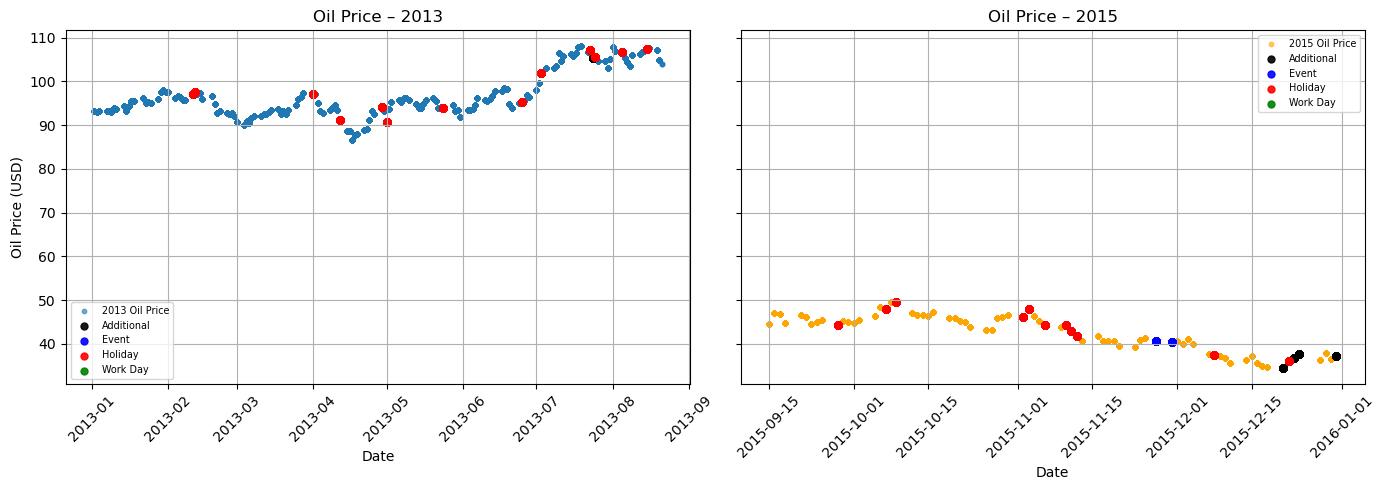

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- Color mapping for holiday types ---
color_map = {
    'Holiday': 'red',
    'Transfer': 'orange',
    'Bridge': 'purple',
    'Work Day': 'green',
    'Event': 'blue'
}

# --- 2013 data ---
axes[0].scatter(df_2013.index, df_2013['oil_price'], s=10, alpha=0.6, label='2013 Oil Price')

# Add holidays for 2013
holidays_2013 = df_2013.dropna(subset=['holiday_type'])
for htype, group in holidays_2013.groupby('holiday_type'):
    axes[0].scatter(
        group.index, group['oil_price'],
        s=25, alpha=0.9,
        color=color_map.get(htype, 'black'),
        label=htype
    )

axes[0].set_title('Oil Price ‚Äì 2013')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Oil Price (USD)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)
axes[0].legend(fontsize='x-small', loc='best')

# --- 2015 data ---
axes[1].scatter(df_2015.index, df_2015['oil_price'], s=10, alpha=0.6, color='orange', label='2015 Oil Price')

# Add holidays for 2015
holidays_2015 = df_2015.dropna(subset=['holiday_type'])
for htype, group in holidays_2015.groupby('holiday_type'):
    axes[1].scatter(
        group.index, group['oil_price'],
        s=25, alpha=0.9,
        color=color_map.get(htype, 'black'),
        label=htype
    )

axes[1].set_title('Oil Price ‚Äì 2015')
axes[1].set_xlabel('Date')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)
axes[1].legend(fontsize='x-small', loc='best')

plt.tight_layout()
plt.show()

--------------------------------------------------------------------------

## EDA of each provided period 2013 and 2015

-----------------------------------------------

## df_2013

### 2013 ‚Äì Growth and High Oil Revenues

In 2013, Ecuador‚Äôs economy was expanding at a healthy pace (around 4‚Äì5% growth). The main sectors were:
	1.	Oil and Mining ‚Äì The cornerstone of the economy, providing the majority of export earnings and government revenue.
	2.	Construction and Public Works ‚Äì Boosted by large-scale government infrastructure projects funded by oil income (roads, housing, and hydroelectric plants).
	3.	Manufacturing ‚Äì Focused on processed foods, beverages, textiles, and construction materials for the domestic market.
	4.	Agriculture and Agroindustry ‚Äì Key non-oil exports included bananas, shrimp, flowers, and cocoa, with agriculture providing broad employment.
	5.	Services and Commerce ‚Äì Retail, finance, and tourism sectors were expanding due to higher consumer spending and urban growth.

	‚Ä¢	Unemployment rate: around 4.6%.
	‚Ä¢	The economy was benefiting from strong public spending and steady job creation in construction, services, and commerce.
	‚Ä¢	Underemployment (informal or part-time work) was still common, especially in rural areas, but overall labor market conditions were stable.

In [71]:
df_2013.shape

(58495, 15)

### General shopping pattern overview during the given 2013 period

for the moment the oil price is high, the economic situation is pretty nice - therefore, no shopping patterns had been effected

In this dataset, the column transactions does not represent money, but rather the number of sales transactions (or receipts) that occurred in the store on that day.

Key points:
	‚Ä¢	One transaction = one sale event at the supermarket (could be one basket, one receipt).
	‚Ä¢	It doesn‚Äôt measure revenue directly, just activity level.
	‚Ä¢	If a store has a high transactions value on a day, it means many customers made purchases, regardless of how much each spent.
	‚Ä¢	You can combine it with unit_sales or oil_price to estimate trends in consumer behavior.

In [72]:
def plot_oil_txn_holidays(df, year_label="2013"):
    # --- Get all unique store types ---
    store_types = df['store_type'].cat.categories if df['store_type'].dtype.name == 'category' else df['store_type'].unique()
    store_types = sorted(store_types)

    # --- Combined plot ---
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Oil price line (same for all stores)
    ax1.plot(df.index, df['oil_price'], color='steelblue', linewidth=2, label='Oil Price (USD)')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Oil Price (USD)', color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')

    # Transactions scatter per store type
    ax2 = ax1.twinx()
    colors = plt.cm.tab10.colors  # color palette for store types
    for i, stype in enumerate(store_types):
        df_store = df[df['store_type'] == stype]
        ax2.scatter(
            df_store.index,
            df_store['transactions'],
            s=10,
            alpha=0.7,
            color=colors[i % len(colors)],
            label=f'Transactions ({stype})'
        )

    ax2.set_ylabel('Transactions', color='darkorange')
    ax2.tick_params(axis='y', labelcolor='darkorange')

    ax1.set_title(f'Ecuador {year_label} ‚Äì Combined: Oil Price and Transactions by Store Type', fontsize=13)
    ax1.grid(True, linestyle='--', alpha=0.6)
    fig.autofmt_xdate(rotation=45)

    # Merge legends
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left', fontsize='small')

    plt.tight_layout()
    plt.show()

    # --- Individual plots (your original logic) ---
    for stype in store_types:
        df_store = df[df['store_type'] == stype].copy()
        if df_store.empty:
            continue

        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Oil price line
        ax1.plot(df_store.index, df_store['oil_price'], color='steelblue', linewidth=2, label='Oil Price (USD)')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Oil Price (USD)', color='steelblue')
        ax1.tick_params(axis='y', labelcolor='steelblue')

        # Transactions
        ax2 = ax1.twinx()
        ax2.scatter(
            df_store.index,
            df_store['transactions'],
            color='darkorange',
            s=10,
            alpha=0.9,
            edgecolors='black',
            linewidths=0.4,
            label='Transactions'
        )
        ax2.set_ylabel('Transactions', color='darkorange')
        ax2.tick_params(axis='y', labelcolor='darkorange')

        # Holidays
        holidays_store = df_store.dropna(subset=['holiday_type']).copy()
        ymin = ax1.get_ylim()[0]
        holiday_colors = {
            'Holiday': 'red',
            'Event': 'blue',
            'Bridge': 'purple',
            'Work Day': 'green',
            'Transfer': 'orange'
        }

        for htype, group in holidays_store.groupby('holiday_type'):
            if htype == 'Transfer':
                ax1.scatter(
                    group.index,
                    [ymin] * len(group),
                    color='orange',
                    s=15,
                    marker='v',
                    alpha=0.9,
                    edgecolors='black',
                    linewidths=0.3,
                    label=f"Transfer ({stype})"
                )
            else:
                locale_val = group['locale'].iloc[0] if not group['locale'].empty else 'N/A'
                transferred_val = group['transferred'].iloc[0] if not group['transferred'].empty else 'N/A'
                ax1.scatter(
                    group.index,
                    [ymin] * len(group),
                    color=holiday_colors.get(htype, 'gray'),
                    s=45,
                    marker='v',
                    alpha=0.9,
                    edgecolors='black',
                    linewidths=0.3,
                    label=f"{htype} ({locale_val}, transferred={transferred_val})"
                )

        ax1.set_title(f'Ecuador {year_label} ‚Äì Oil Price, Transactions, and Holidays (Store Type {stype})', fontsize=13)
        ax1.grid(True, linestyle='--', alpha=0.6)
        fig.autofmt_xdate(rotation=45)

        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left', fontsize='small')

        plt.tight_layout()
        plt.show()

In [73]:
df_2013.sample(5)

unit_sales store_nbr item_nbr  onpromotion  oil_price  \
2013-01-03         5.0        24   464333        False  92.970001   
2013-01-29         6.0        37   557257        False  97.620003   
2013-05-10         3.0         8  1071928        False  95.809998   
2013-03-16        13.0         4   363868        False        NaN   
2013-01-10         7.0        50   865147        False  93.809998   

           holiday_type locale  transferred       city store_type  \
2013-01-03          NaN    NaN         True  Guayaquil          D   
2013-01-29          NaN    NaN         True     Cuenca          D   
2013-05-10          NaN    NaN         True      Quito          D   
2013-03-16          NaN    NaN         True      Quito          D   
2013-01-10          NaN    NaN         True     Ambato          A   

           store_cluster   items_family item_class  perishable_items  \
2013-01-03             1      GROCERY I       1040             False   
2013-01-29             2           EGGS       2502              True   
2013-05-10             8  PERSONAL CARE       4114             False   
2013-03-16             9      GROCERY I       1016             False   
2013-01-10            14  PERSONAL CARE       4114             False   

            transactions  
2013-01-03          2462  
2013-01-29          1273  
2013-05-10          3025  
2013-03-16          1631  
2013-01-10          2052

/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/3584205508.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for htype, group in holidays_store.groupby('holiday_type'):


/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/3584205508.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for htype, group in holidays_store.groupby('holiday_type'):


/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/3584205508.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for htype, group in holidays_store.groupby('holiday_type'):


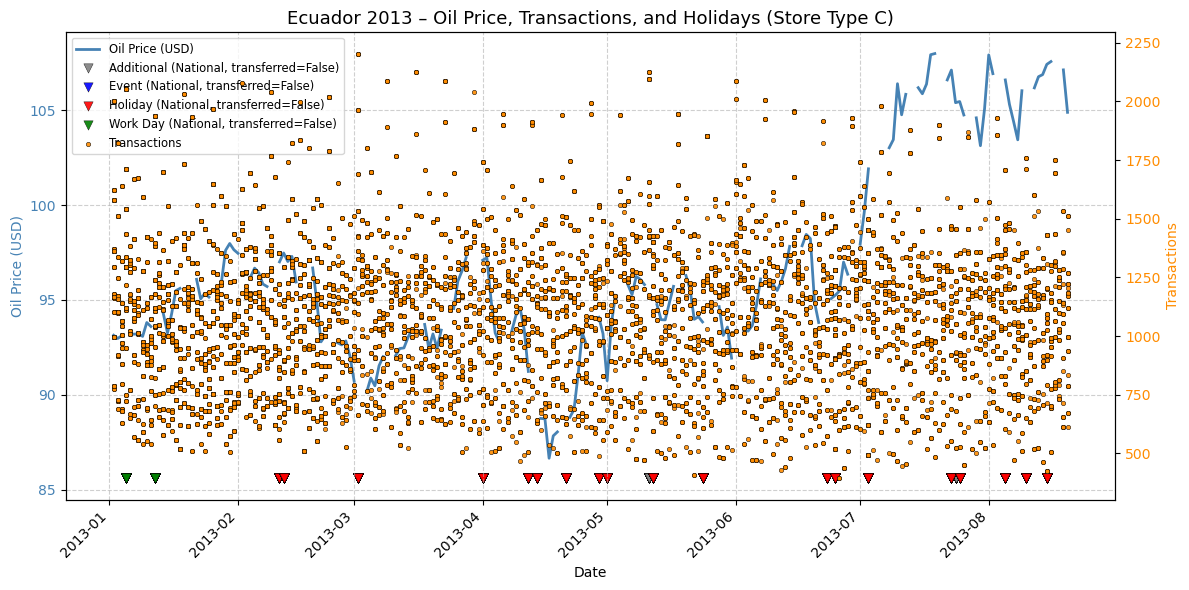

/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/3584205508.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for htype, group in holidays_store.groupby('holiday_type'):


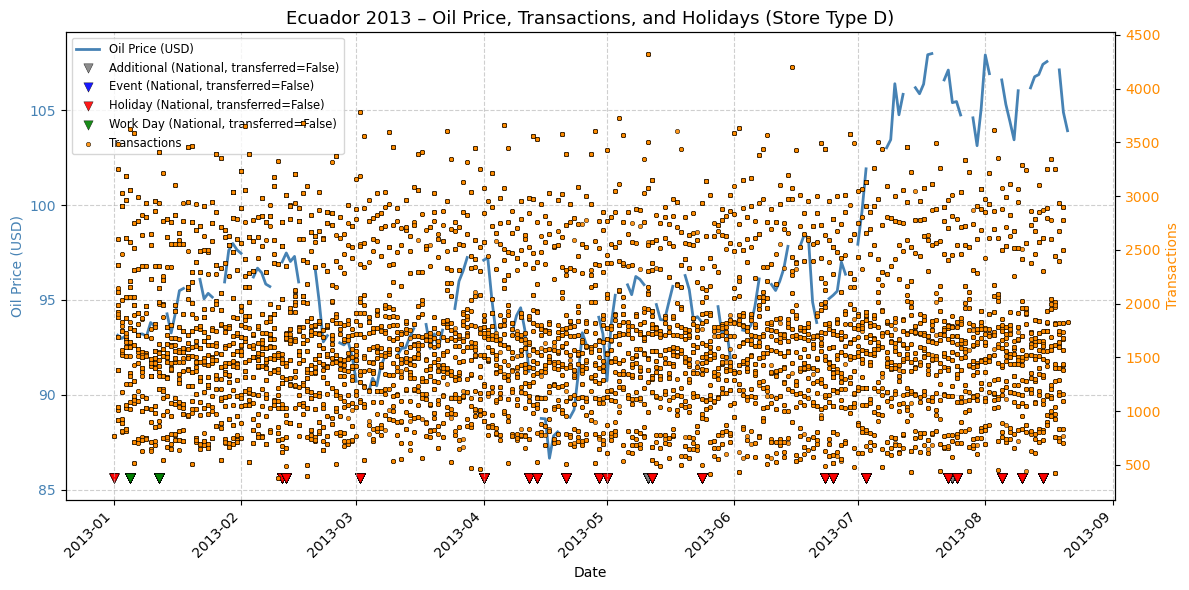

/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/3584205508.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for htype, group in holidays_store.groupby('holiday_type'):


In [74]:
plot_oil_txn_holidays(df_2013, year_label="2013")

In [75]:
df_2013.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58495 entries, 2013-01-01 to 2013-08-21
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   unit_sales        58495 non-null  float32 
 1   store_nbr         58495 non-null  object  
 2   item_nbr          58495 non-null  object  
 3   onpromotion       58495 non-null  bool    
 4   oil_price         39633 non-null  float32 
 5   holiday_type      6446 non-null   category
 6   locale            6446 non-null   category
 7   transferred       58495 non-null  bool    
 8   city              58495 non-null  category
 9   store_type        58495 non-null  category
 10  store_cluster     58495 non-null  category
 11  items_family      58495 non-null  category
 12  item_class        58495 non-null  object  
 13  perishable_items  58495 non-null  bool    
 14  transactions      58495 non-null  int16   
dtypes: bool(3), category(6), float32(2), int16(1), object

---------------------------------------------------------------------------------

## df_2015

### 2015 ‚Äì Adjustment and Slower Growth

By 2015, the sharp decline in oil prices and a strong U.S. dollar (Ecuador‚Äôs official currency) slowed the economy. Key sectors were similar but affected differently:
	1.	Oil Sector ‚Äì Still strategic but hit hard by low prices, reducing public revenues and investment.
	2.	Construction ‚Äì Declined significantly as government budgets tightened.
	3.	Agriculture and Fishing ‚Äì Remained resilient; shrimp and banana exports continued to perform well, partially offsetting oil losses.
	4.	Manufacturing ‚Äì Faced import restrictions and lower domestic demand due to fiscal tightening.
	5.	Services ‚Äì Continued to be important, though growth slowed in retail and tourism.

	‚Ä¢	Unemployment rate: around 4.8‚Äì5.0%, slightly higher than in 2013.
	‚Ä¢	The collapse in oil prices slowed economic growth, leading to reduced public investment and weaker job creation.
	‚Ä¢	Informal employment and part-time work increased as the government and private sector both tightened budgets.

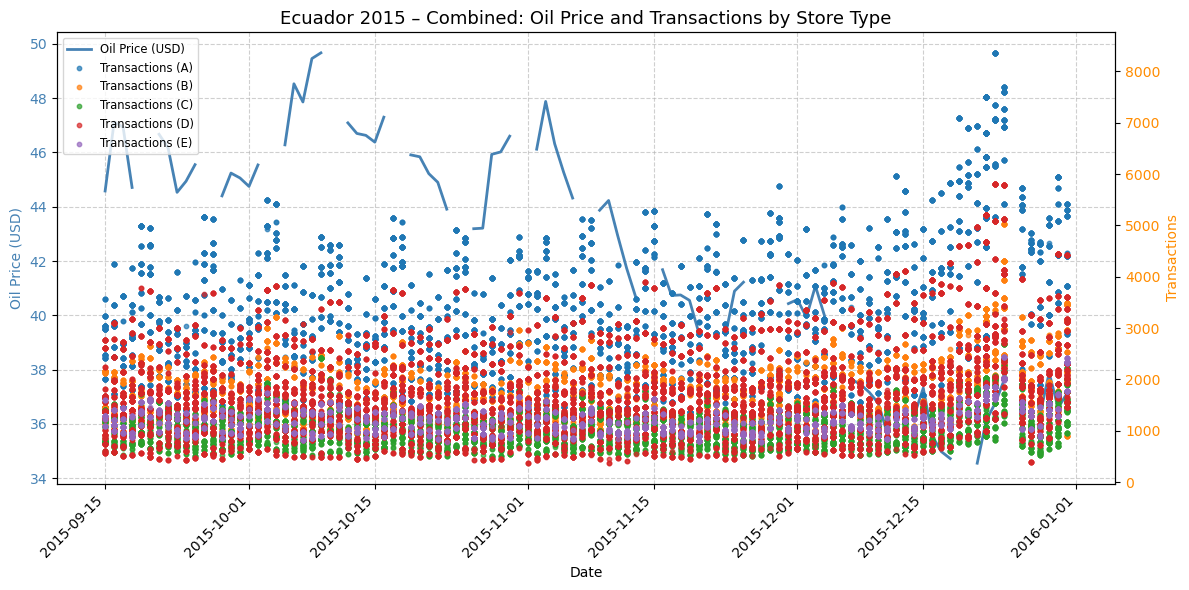

/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/3584205508.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for htype, group in holidays_store.groupby('holiday_type'):


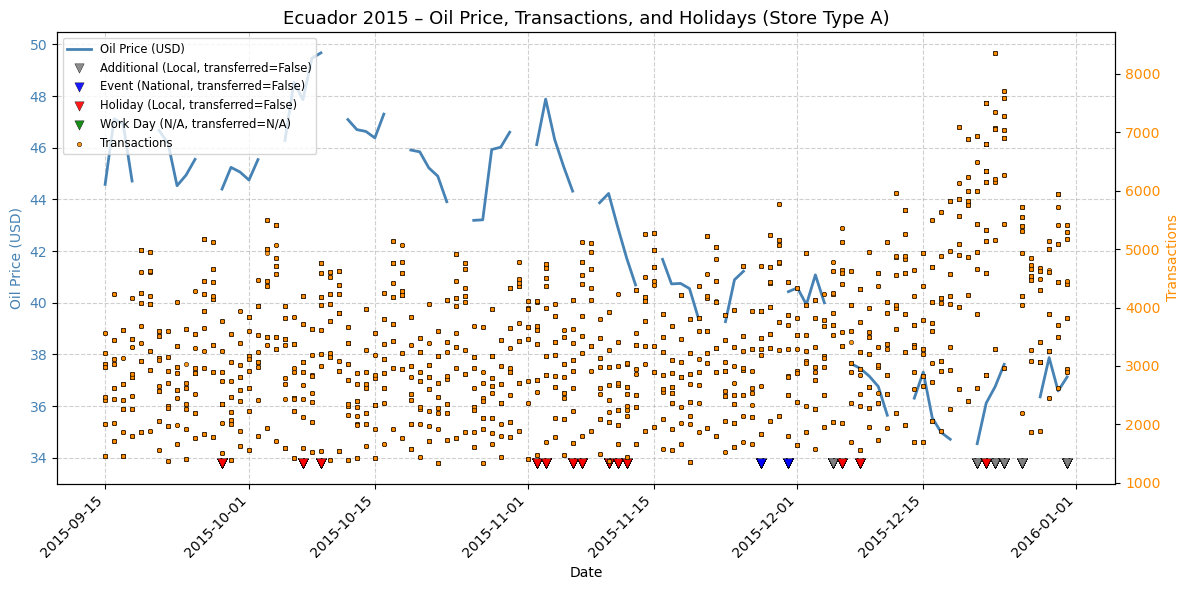

/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/3584205508.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for htype, group in holidays_store.groupby('holiday_type'):


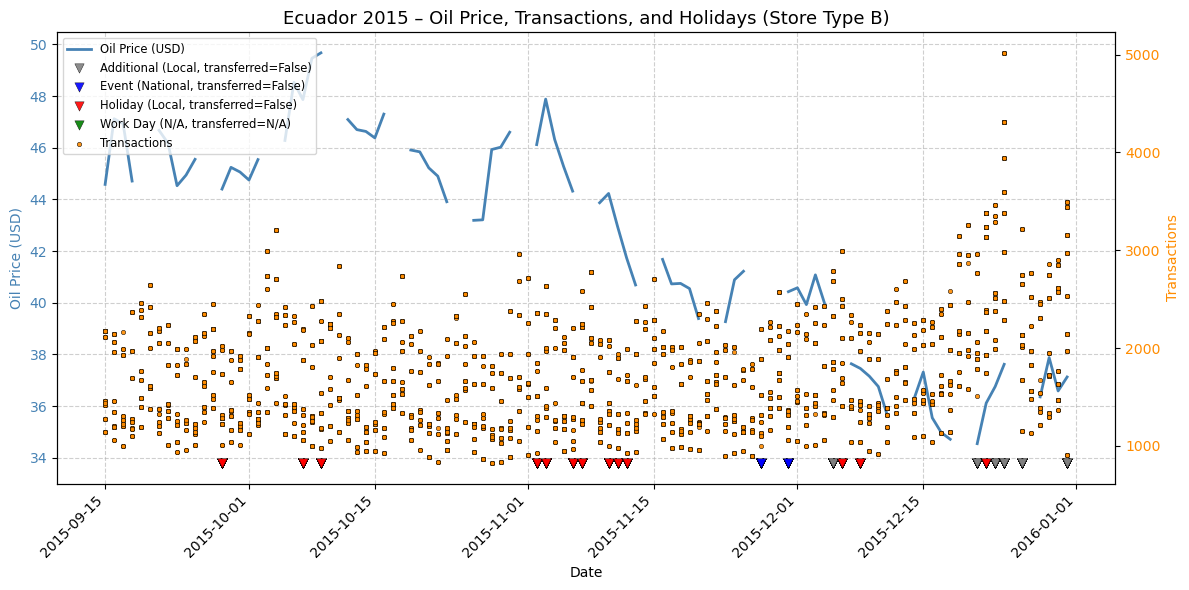

/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/3584205508.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for htype, group in holidays_store.groupby('holiday_type'):


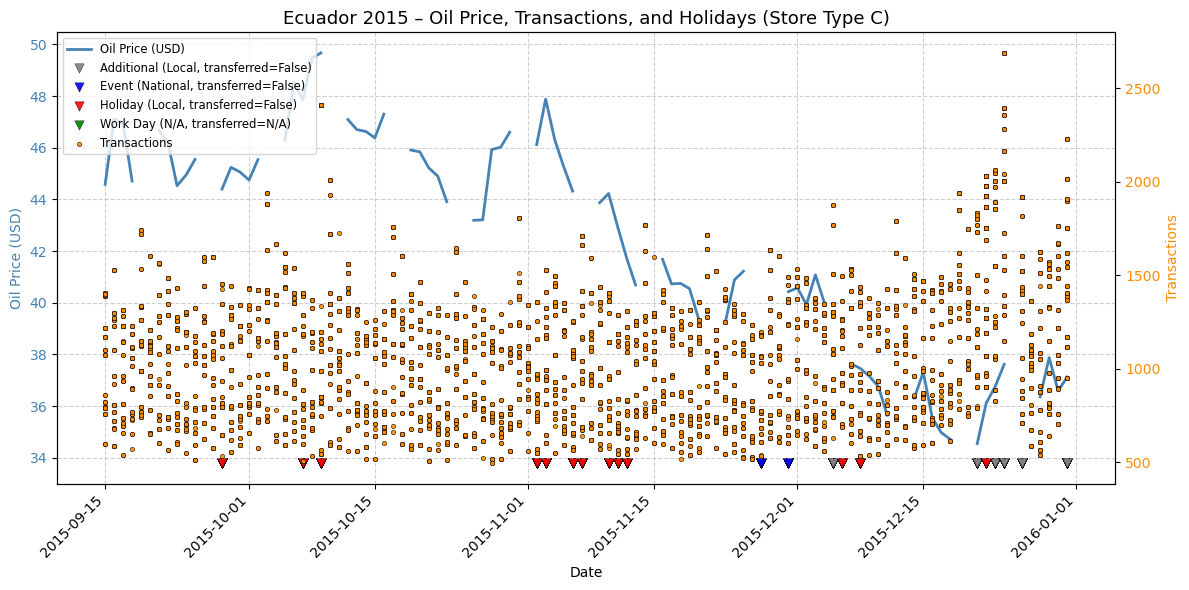

/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/3584205508.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for htype, group in holidays_store.groupby('holiday_type'):


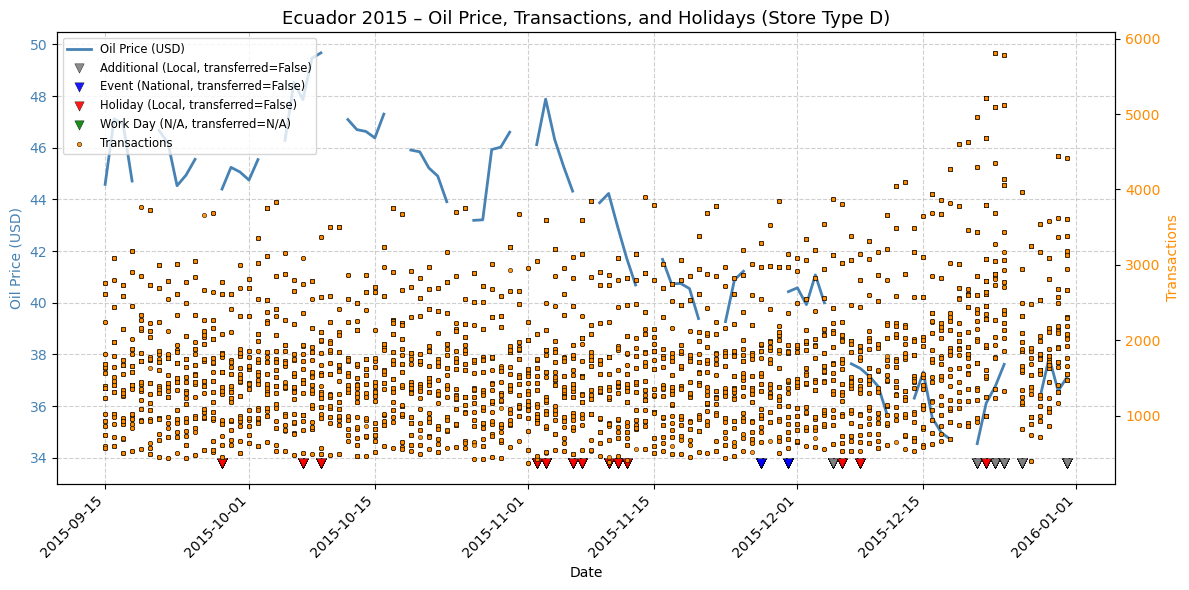

/var/folders/tc/j3328fdx0g5254lv79p9t1bc0000gn/T/ipykernel_1136/3584205508.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for htype, group in holidays_store.groupby('holiday_type'):


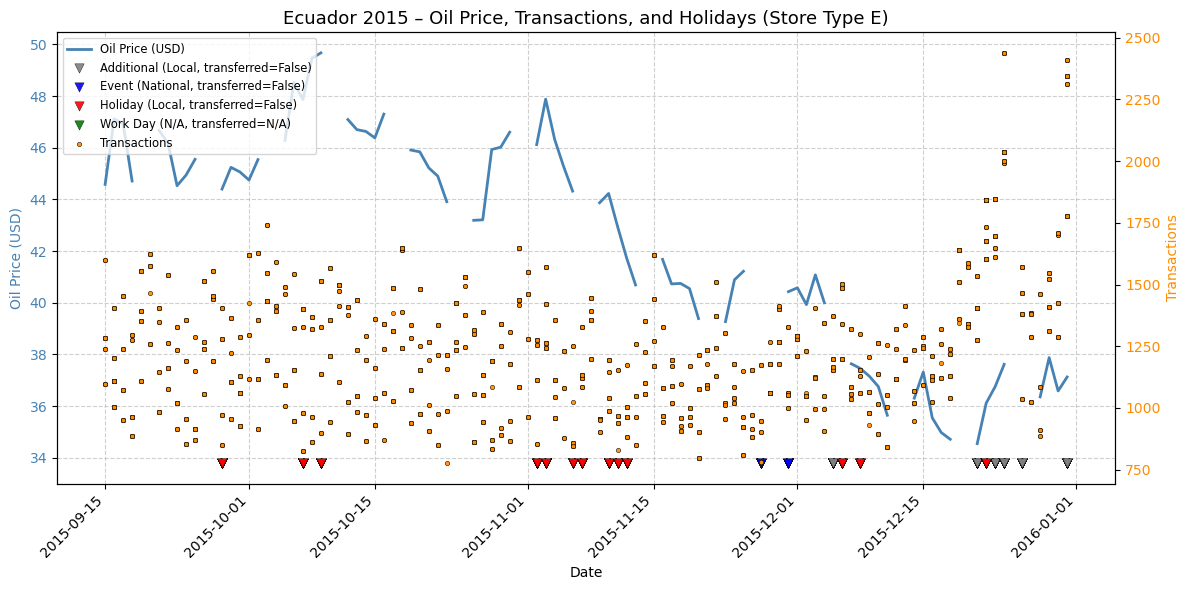

In [76]:
plot_oil_txn_holidays(df_2015, year_label="2015")

even in time of economic hardship - people still making greater shopping on Christmas